In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3
from algo.dqn import DQN

from logger import *
setup_logging(default_level=logging.INFO)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)

# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)


state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = np.arange(3)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Online mode DQN
- mountain car has reward of -1 everywhere and dqn's prediction is likely initialized around zero. It's very optimistic and therefore it will end up exploring as much as possible wherever it did not get -1's. therefore epsilon can be very low.
- the learning rate matters

In [9]:
import tensorflow as tf

# test online dqn
with tf.Graph().as_default():
    dqn = DQN(env,
               D=None,
               hiddens=[128, 64],
               learning_rate=1e-4,
               gamma=0.99,
               buffer_size=50000,
               max_timesteps=10**5,
               print_freq=100,
               layer_norm=True,
               exploration_fraction=0.0001,
               exploration_final_eps=0.0001,
               param_noise=True,
               grad_norm_clipping=10,
               buffer_batch_size=32)


In [10]:
with tf.Graph().as_default():
    dqn.train(use_batch=False)

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 30       |
| mean 100 episode reward | -200     |
| steps                   | 5799     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 60       |
| mean 100 episode reward | -199     |
| steps                   | 11734    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 90       |
| mean 100 episode reward | -197     |
| steps                   | 17520    |
--------------------------------------
Saving model due to mean reward increase: None -> -197.2
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 120      |
| mean 100 episode reward | -196     |
| steps                   | 23353    |
--------------------------------------
-------

INFO:tensorflow:Restoring parameters from /tmp/tmpvwzwhii1/model


Saving model to mountaincar_model.pkl


In [ ]:
# PERcheck ?


## Batch mode DQN
- generate three types of D

In [9]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = 0
        #c = np.random.uniform(-0.1, 0.1)
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.2, 0.2)
        return 0 if v > c else 2
    
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)
pi_expert = pi_near

# mixed training set
pi_list = [pi_random, pi_near_ops, pi_near]
mix_ratio = [0.5, 0.1, 0.4]

D_mixed_size = 100
D_mixed = sim.simulate_mixed(env, pi_list, D_mixed_size, mix_ratio)
D_mixed_mat = Simulator.to_matrix(D_mixed)

# pure expert
D_pure_size = 30
D_pure = sim.simulate(pi_expert, 1, D_pure_size)
D_pure_mat = Simulator.to_matrix(D_pure)

def generate_state_samples(env, pi, n_sample=1000):
    """
    a hacky way to cover most state space uniformly
    """
    D = []
    states=np.array([env.observation_space.sample() for _ in range(n_sample)])
    for s in states:
        env.reset(s)
        a = pi.choose_action(s)
        s_next, r, done, _ = env.step(a)
        # one transition = one episode
        absorb = s_next[0] > 0.5 or s[0] > 0.5
        D.append([[s, a, r, s_next, absorb, done]])
    return D

D_fake_size = 3000
D_fake = generate_state_samples(env, pi_random, D_fake_size)
D_fake_mat = Simulator.to_matrix(D_fake)

Step 153 @ Episode 30/30 (-159.0)

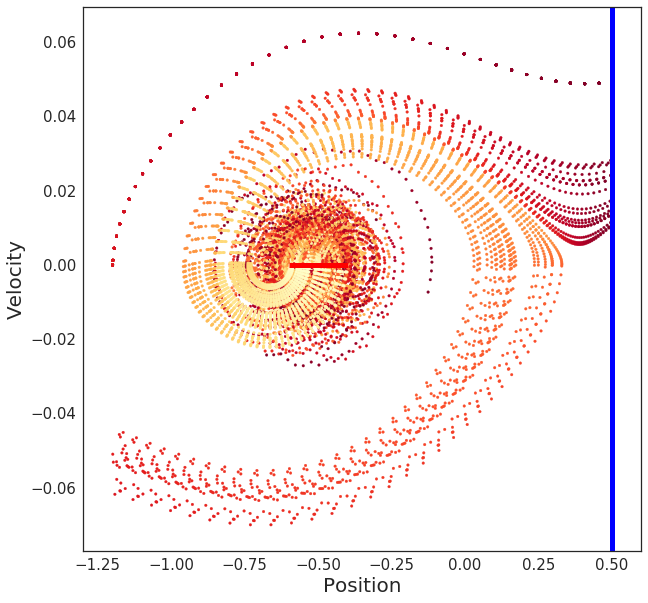

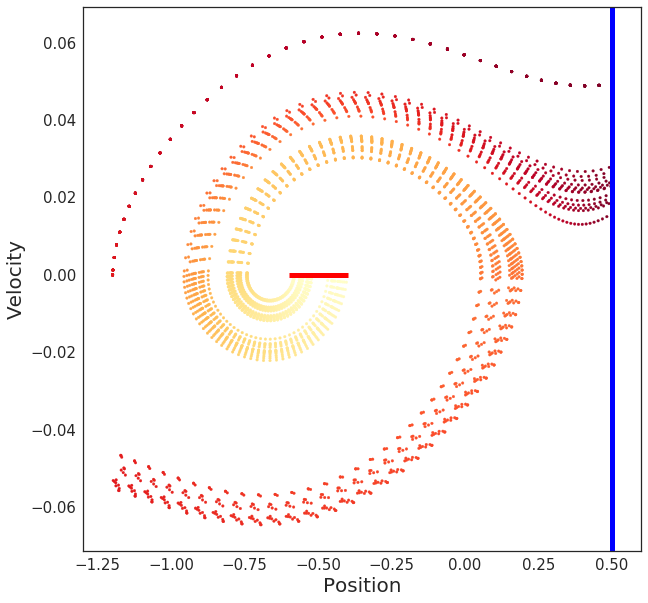

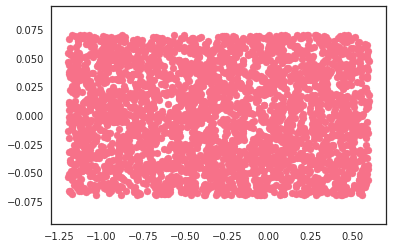

In [10]:
plot_trajectory_mountain_car(D_mixed)
plot_trajectory_mountain_car(D_pure)
synthetic=np.array([env.observation_space.sample() for _ in range(D_fake_size)])
plt.scatter(synthetic[:, 0], synthetic[:, 1])

## train with fake data

In [29]:
import tensorflow as tf
# use PER
# test online dqn
with tf.Graph().as_default():
    dqn = DQN(env,
               D=D_mixed_mat,
               hiddens=[128, 64],
               learning_rate=1e-4,
               gamma=0.99,
               buffer_size=50000,
               max_timesteps=10**5,
               print_freq=100,
               layer_norm=True,
               exploration_fraction=0.0001,
               exploration_final_eps=0.0001,
               policy_evaluate_freq=1000,
               param_noise=True,
               grad_norm_clipping=10,
               buffer_batch_size=32)


INFO:root:dumping D of size (17216, 6) into experience replay


In [33]:
with tf.Graph().as_default():
    dqn.train(use_batch=True)

INFO:root:been trained 0 steps
INFO:root:been trained 500 steps
INFO:root:been trained 1000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1500 steps
INFO:root:been trained 2000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2500 steps
INFO:root:been trained 3000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 3500 steps
INFO:root:been trained 4000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 4500 steps
INFO:root:been trained 5000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 5500 steps
INFO:root:been trained 6000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 6500 steps
INFO:root:been trained 7000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 7500 steps
INFO:root:been trained 8000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 8500 steps
INFO:root:been trained 9000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 9500 steps
INFO:root:been trained 10000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 10500 steps
INFO:root:been trained 11000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 11500 steps
INFO:root:been trained 12000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


KeyboardInterrupt: 